In [7]:
import requests
import pandas as pd
import json
import io
import datetime
import pandas as pd
import numpy as np
import requests
import base64
import json
from calendar import monthrange
import pymongo
from mongoengine import StringField, ListField, DateTimeField, DictField
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator



def mongo_unavs_call():
    print("Starting mongo_unavs_call")
    # Connect to the MongoDB database
    user = "dmarroquin"
    passw = "tN9XpCCQM2MtYDme"
    host = "nucmonitordata.xxcwx9k.mongodb.net"
    client = pymongo.MongoClient(
        f"mongodb+srv://{user}:{passw}@{host}/?retryWrites=true&w=majority&connectTimeoutMS=5000"
    )

    db = client["data"]
    collection_past_unavs = db["unavs"]
    collection_unavs =db["unavs_update"]

    start_date = "2019-01-01T00:00:00"
    end_date = "2020-12-31T23:59:59"
    
    pipeline = [
        {
            "$unwind": "$results"
        },
        {
            "$unwind": "$results.generation_unavailabilities"
        },
        {
            "$match": {
                "results.generation_unavailabilities.production_type": "NUCLEAR",
                "results.generation_unavailabilities.start_date": {"$lte": end_date},
                "results.generation_unavailabilities.end_date": {"$gte": start_date},
                "results.generation_unavailabilities.updated_date": {"$lte": end_date}
            }
        },
        {
            "$project": {
                "_id": 0,
                "generation_unavailabilities": "$results.generation_unavailabilities"
            }
        }
    ]

    result1 = list(collection_past_unavs.aggregate(pipeline))
    result2 = list(collection_unavs.aggregate(pipeline))
    
    # Merge the two lists of JSON results
    merged_result = result1 + result2

    return merged_result

# Store normal size data
def mongo_store_data(data, database_name, collection_name):
    # Credentials
    user = "dmarroquin"
    passw = "tN9XpCCQM2MtYDme"
    host = "nucmonitordata.xxcwx9k.mongodb.net"

    # Connect to the MongoDB database
    client =  pymongo.MongoClient(
    "mongodb+srv://{0}:{1}@{2}/?retryWrites=true&w=majority&connectTimeoutMS=5000" \
    .format(user, passw, host))

    db = client[database_name]
    collection = db[collection_name]

    # Insert the data into the collection
    collection.insert_one(data)

    # Close the database connection
    client.close()

In [8]:
data = mongo_unavs_call()
data

Starting mongo_unavs_call


[{'generation_unavailabilities': {'identifier': 'EC-EDF-05470-EDF-T-00011827',
   'version': '54',
   'creation_date': '2015-04-22T15:39:00+02:00',
   'updated_date': '2019-01-27T21:41:00+01:00',
   'start_date': '2018-04-07T02:00:00+02:00',
   'end_date': '2019-01-27T21:25:00+01:00',
   'type': 'PLANNED_MAINTENANCE',
   'production_type': 'NUCLEAR',
   'producer': 'EDF',
   'eic_code_producer': '17X100A100R00182',
   'message_id': '-EDF-05470-EDF-T-00011827_054',
   'unit': {'eic_code': '17W100P100P0126N',
    'name': 'FLAMANVILLE 1',
    'type': 'GENERATING_UNIT',
    'installed_capacity': 1330},
   'reason': 'Information ComplÃ©mentaire / Complementary Information',
   'remarks': 'After its restart, the plant will gradually return by various load thresholds to full power. The ramp-up period will take at least 48 hours.\nFirst threshold after restart : 69 MW\n-------------------------------------\nAprès son recouplage, la tranche remontera progressivement par palier de charge à sa pl

In [9]:
mongo_df = pd.DataFrame(data)

# Unpack the dictionaries into separate columns
mongo_df_unpacked = pd.json_normalize(mongo_df['generation_unavailabilities'])

# Concatenate the unpacked columns with the original DataFrame
mongo_df_result = pd.concat([mongo_df, mongo_df_unpacked], axis=1)

# Drop the original column
mongo_df_result.drop(columns=['generation_unavailabilities'], inplace=True)
mongo_df_columns = mongo_df_result.columns

mongo_df_result['start_date'] = mongo_df_result['values'].apply(lambda x: x[0]['start_date'])
mongo_df_result['end_date'] = mongo_df_result['values'].apply(lambda x: x[0]['end_date'])
mongo_df_result['available_capacity'] = mongo_df_result['values'].apply(lambda x: x[0]['available_capacity'])
mongo_df_result['unavailable_capacity'] = mongo_df_result['values'].apply(lambda x: x[0]['unavailable_capacity'])
# print(mongo_df_result)
# print(mongo_df_result.columns)
# Drop the original 'values' column
mongo_df_result.drop('values', axis=1, inplace=True)
mongo_df2 = mongo_df_result
mongo_df2.rename(columns=lambda col: col.replace('unit.', ''), inplace=True)

# --------------------- INITIAL DATA CLEANING FOR MONGO DATA ------------------------ #   

# Make the two dataframes have the same columns
mongo_unavs = mongo_df2.copy()
mongo_unavs.drop(columns="type", inplace=True)
mongo_unavs

,identifier,version,creation_date,updated_date,start_date,end_date,production_type,producer,eic_code_producer,message_id,reason,remarks,status,eic_code,name,installed_capacity,available_capacity,unavailable_capacity
0,EC-EDF-05470-EDF-T-00011827,54,2015-04-22T15:39:00+02:00,2019-01-27T21:41:00+01:00,2018-04-07T02:00:00+02:00,2019-01-27T21:25:00+01:00,NUCLEAR,EDF,17X100A100R00182,-EDF-05470-EDF-T-00011827_054,Information ComplÃ©mentaire / Complementary In...,"After its restart, the plant will gradually re...",INACTIVE,17W100P100P0126N,FLAMANVILLE 1,1330,0,1330
1,EC-EDF-05470-EDF-T-00011827,53,2015-04-22T15:39:00+02:00,2019-01-27T20:45:00+01:00,2018-04-07T02:00:00+02:00,2019-01-27T21:00:00+01:00,NUCLEAR,EDF,17X100A100R00182,-EDF-05470-EDF-T-00011827_053,Information ComplÃ©mentaire / Complementary In...,"After its restart, the plant will gradually re...",ACTIVE,17W100P100P0126N,FLAMANVILLE 1,1330,0,1330
2,EC-EDF-05470-EDF-T-00011827,52,2015-04-22T15:39:00+02:00,2019-01-27T19:10:00+01:00,2018-04-07T02:00:00+02:00,2019-01-27T20:00:00+01:00,NUCLEAR,EDF,17X100A100R00182,-EDF-05470-EDF-T-00011827_052,Information ComplÃ©mentaire / Complementary In...,"After its restart, the plant will gradually re...",ACTIVE,17W100P100P0126N,FLAMANVILLE 1,1330,0,1330
3,EC-EDF-05470-EDF-T-00011827,51,2015-04-22T15:39:00+02:00,2019-01-27T17:55:00+01:00,2018-04-07T02:00:00+02:00,2019-01-27T19:00:00+01:00,NUCLEAR,EDF,17X100A100R00182,-EDF-05470-EDF-T-00011827_051,Information ComplÃ©mentaire / Complementary In...,"After its restart, the plant will gradually re...",ACTIVE,17W100P100P0126N,FLAMANVILLE 1,1330,0,1330
4,EC-EDF-05470-EDF-T-00011827,50,2015-04-22T15:39:00+02:00,2019-01-27T05:35:00+01:00,2018-04-07T02:00:00+02:00,2019-01-27T18:00:00+01:00,NUCLEAR,EDF,17X100A100R00182,-EDF-05470-EDF-T-00011827_050,Information ComplÃ©mentaire / Complementary In...,"After its restart, the plant will gradually re...",ACTIVE,17W100P100P0126N,FLAMANVILLE 1,1330,0,1330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19607,EC-EDF-05470-EDF-T-00024691,6,2017-09-05T02:54:00+02:00,2019-05-14T12:54:00+02:00,2020-06-30T00:00:00+02:00,2099-12-31T02:00:00+01:00,NUCLEAR,EDF,17X100A100R00182,-EDF-05470-EDF-T-00024691_006,Information ComplÃ©mentaire / Complementary In...,For more information please refer to REMIT mes...,ACTIVE,17W100P100P0125P,FESSENHEIM 2,880,0,880
19608,EC-EDF-05470-EDF-T-00024691,5,2017-09-05T02:54:00+02:00,2018-07-31T10:04:00+02:00,2019-11-30T00:00:00+01:00,2099-12-31T02:00:00+01:00,NUCLEAR,EDF,17X100A100R00182,-EDF-05470-EDF-T-00024691_005,Information ComplÃ©mentaire / Complementary In...,The French Energy Transition Act limits nuclea...,ACTIVE,17W100P100P0125P,FESSENHEIM 2,880,0,880
19609,EC-EDF-05470-EDF-T-00024691,4,2017-09-05T02:54:00+02:00,2018-07-25T09:39:00+02:00,2019-07-01T00:00:00+02:00,2099-12-31T02:00:00+01:00,NUCLEAR,EDF,17X100A100R00182,-EDF-05470-EDF-T-00024691_004,Information ComplÃ©mentaire / Complementary In...,The French Energy Transition Act limits nuclea...,ACTIVE,17W100P100P0125P,FESSENHEIM 2,880,0,880
19610,EC-EDF-05470-EDF-T-00024691,3,2017-09-05T02:54:00+02:00,2018-05-31T18:49:00+02:00,2019-07-01T00:00:00+02:00,2099-12-31T02:00:00+01:00,NUCLEAR,EDF,17X100A100R00182,-EDF-05470-EDF-T-00024691_003,Information ComplÃ©mentaire / Complementary In...,The French Energy Transition Act limits nuclea...,ACTIVE,17W100P100P0125P,FESSENHEIM 2,880,0,880


In [10]:
past_date_str = "2023-09-25T23:59:59"
nuclear_unav = mongo_unavs.copy()[(mongo_unavs.copy()["production_type"] == "NUCLEAR") & (mongo_unavs.copy()["updated_date"] <= past_date_str)]
nuclear_unav

,identifier,version,creation_date,updated_date,start_date,end_date,production_type,producer,eic_code_producer,message_id,reason,remarks,status,eic_code,name,installed_capacity,available_capacity,unavailable_capacity
0,EC-EDF-05470-EDF-T-00011827,54,2015-04-22T15:39:00+02:00,2019-01-27T21:41:00+01:00,2018-04-07T02:00:00+02:00,2019-01-27T21:25:00+01:00,NUCLEAR,EDF,17X100A100R00182,-EDF-05470-EDF-T-00011827_054,Information ComplÃ©mentaire / Complementary In...,"After its restart, the plant will gradually re...",INACTIVE,17W100P100P0126N,FLAMANVILLE 1,1330,0,1330
1,EC-EDF-05470-EDF-T-00011827,53,2015-04-22T15:39:00+02:00,2019-01-27T20:45:00+01:00,2018-04-07T02:00:00+02:00,2019-01-27T21:00:00+01:00,NUCLEAR,EDF,17X100A100R00182,-EDF-05470-EDF-T-00011827_053,Information ComplÃ©mentaire / Complementary In...,"After its restart, the plant will gradually re...",ACTIVE,17W100P100P0126N,FLAMANVILLE 1,1330,0,1330
2,EC-EDF-05470-EDF-T-00011827,52,2015-04-22T15:39:00+02:00,2019-01-27T19:10:00+01:00,2018-04-07T02:00:00+02:00,2019-01-27T20:00:00+01:00,NUCLEAR,EDF,17X100A100R00182,-EDF-05470-EDF-T-00011827_052,Information ComplÃ©mentaire / Complementary In...,"After its restart, the plant will gradually re...",ACTIVE,17W100P100P0126N,FLAMANVILLE 1,1330,0,1330
3,EC-EDF-05470-EDF-T-00011827,51,2015-04-22T15:39:00+02:00,2019-01-27T17:55:00+01:00,2018-04-07T02:00:00+02:00,2019-01-27T19:00:00+01:00,NUCLEAR,EDF,17X100A100R00182,-EDF-05470-EDF-T-00011827_051,Information ComplÃ©mentaire / Complementary In...,"After its restart, the plant will gradually re...",ACTIVE,17W100P100P0126N,FLAMANVILLE 1,1330,0,1330
4,EC-EDF-05470-EDF-T-00011827,50,2015-04-22T15:39:00+02:00,2019-01-27T05:35:00+01:00,2018-04-07T02:00:00+02:00,2019-01-27T18:00:00+01:00,NUCLEAR,EDF,17X100A100R00182,-EDF-05470-EDF-T-00011827_050,Information ComplÃ©mentaire / Complementary In...,"After its restart, the plant will gradually re...",ACTIVE,17W100P100P0126N,FLAMANVILLE 1,1330,0,1330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19607,EC-EDF-05470-EDF-T-00024691,6,2017-09-05T02:54:00+02:00,2019-05-14T12:54:00+02:00,2020-06-30T00:00:00+02:00,2099-12-31T02:00:00+01:00,NUCLEAR,EDF,17X100A100R00182,-EDF-05470-EDF-T-00024691_006,Information ComplÃ©mentaire / Complementary In...,For more information please refer to REMIT mes...,ACTIVE,17W100P100P0125P,FESSENHEIM 2,880,0,880
19608,EC-EDF-05470-EDF-T-00024691,5,2017-09-05T02:54:00+02:00,2018-07-31T10:04:00+02:00,2019-11-30T00:00:00+01:00,2099-12-31T02:00:00+01:00,NUCLEAR,EDF,17X100A100R00182,-EDF-05470-EDF-T-00024691_005,Information ComplÃ©mentaire / Complementary In...,The French Energy Transition Act limits nuclea...,ACTIVE,17W100P100P0125P,FESSENHEIM 2,880,0,880
19609,EC-EDF-05470-EDF-T-00024691,4,2017-09-05T02:54:00+02:00,2018-07-25T09:39:00+02:00,2019-07-01T00:00:00+02:00,2099-12-31T02:00:00+01:00,NUCLEAR,EDF,17X100A100R00182,-EDF-05470-EDF-T-00024691_004,Information ComplÃ©mentaire / Complementary In...,The French Energy Transition Act limits nuclea...,ACTIVE,17W100P100P0125P,FESSENHEIM 2,880,0,880
19610,EC-EDF-05470-EDF-T-00024691,3,2017-09-05T02:54:00+02:00,2018-05-31T18:49:00+02:00,2019-07-01T00:00:00+02:00,2099-12-31T02:00:00+01:00,NUCLEAR,EDF,17X100A100R00182,-EDF-05470-EDF-T-00024691_003,Information ComplÃ©mentaire / Complementary In...,The French Energy Transition Act limits nuclea...,ACTIVE,17W100P100P0125P,FESSENHEIM 2,880,0,880


In [11]:
# Sort by updated date
sorted_df = nuclear_unav.copy().sort_values(by='updated_date')

sorted_df = sorted_df.copy().reset_index(drop=True)

# Filter to get identifiers
filtered_id_df = sorted_df.copy()
filtered_id_df.drop_duplicates(subset='identifier', keep='last', inplace=True)
filtered_id_df = filtered_id_df.copy().reset_index(drop=True)

# This filter should take all the dates with unavs that include days with unavs in the range of the start and end date

filtered_df = filtered_id_df.copy()
# Create a boolean mask to identify rows where status is "Dismissed"
mask = filtered_df["status"] == "DISMISSED"
print(filtered_df["status"])
print(filtered_df[mask])

# Update available_capacity where the condition is True
filtered_df.loc[mask, "available_capacity"] = filtered_df.loc[mask, "installed_capacity"]

# Standardize datetime in dataframe
filtered_df2 = filtered_df.copy() # This code will just standardize datetime stuff
filtered_df2['creation_date'] = pd.to_datetime(filtered_df2['creation_date'], utc=True)
filtered_df2['updated_date'] = pd.to_datetime(filtered_df2['updated_date'], utc=True)
filtered_df2['start_date'] = pd.to_datetime(filtered_df2['start_date'], utc=True)
filtered_df2['end_date'] = pd.to_datetime(filtered_df2['end_date'], utc=True)

# Drop the duplicates
filtered_df3 = filtered_df2.copy().drop_duplicates()
filtered_df3
# Turn df into dict for json processing
# filtered_unavs = filtered_df3.copy().to_dict(orient='records')


0       DISMISSED
1       DISMISSED
2       DISMISSED
3       DISMISSED
4       DISMISSED
          ...    
2118       ACTIVE
2119     INACTIVE
2120       ACTIVE
2121       ACTIVE
2122       ACTIVE
Name: status, Length: 2123, dtype: object
                       identifier version              creation_date  \
0     EC-EDF-05470-EDF-T-00019371       2  2016-07-08T16:03:00+02:00   
1     EC-EDF-05470-EDF-T-00019370       2  2016-07-08T16:00:00+02:00   
2     EC-EDF-05470-EDF-T-00017461       2  2016-03-24T18:02:00+01:00   
3     EC-EDF-05470-EDF-T-00019572       2  2016-07-21T09:01:00+02:00   
4     EC-EDF-05470-EDF-T-00020636       2  2016-09-22T11:30:00+02:00   
...                           ...     ...                        ...   
2040  EC-EDF-05470-EDF-T-00051428       4  2020-12-01T11:08:00+01:00   
2044  EC-EDF-05470-EDF-T-00051464       3  2020-12-03T12:50:00+01:00   
2061  EC-EDF-05470-EDF-T-00023936      21  2017-05-09T02:28:00+02:00   
2065  EC-EDF-05470-EDF-T-00051624       

,identifier,version,creation_date,updated_date,start_date,end_date,production_type,producer,eic_code_producer,message_id,reason,remarks,status,eic_code,name,installed_capacity,available_capacity,unavailable_capacity
0,EC-EDF-05470-EDF-T-00019371,2,2016-07-08 14:03:00+00:00,2016-07-08 14:12:00+00:00,2019-06-29 00:00:00+00:00,2019-08-31 00:00:00+00:00,NUCLEAR,EDF,17X100A100R00182,-EDF-05470-EDF-T-00019371_002,Information ComplÃ©mentaire / Complementary In...,"After its re-coupling, the plant will graduall...",DISMISSED,17W100P100P0131U,GRAVELINES 2,910,910,910
1,EC-EDF-05470-EDF-T-00019370,2,2016-07-08 14:00:00+00:00,2016-07-08 14:16:00+00:00,2019-06-29 00:00:00+00:00,2019-09-03 00:00:00+00:00,NUCLEAR,EDF,17X100A100R00182,-EDF-05470-EDF-T-00019370_002,Information ComplÃ©mentaire / Complementary In...,"After its re-coupling, the plant will graduall...",DISMISSED,17W100P100P0120Z,DAMPIERRE 1,890,890,890
2,EC-EDF-05470-EDF-T-00017461,2,2016-03-24 17:02:00+00:00,2016-07-20 13:36:00+00:00,2019-03-09 01:00:00+00:00,2019-05-12 00:00:00+00:00,NUCLEAR,EDF,17X100A100R00182,-EDF-05470-EDF-T-00017461_002,Information ComplÃ©mentaire / Complementary In...,"After its re-coupling, the plant will graduall...",DISMISSED,17W100P100P0116Q,CRUAS 2,915,915,915
3,EC-EDF-05470-EDF-T-00019572,2,2016-07-21 07:01:00+00:00,2016-10-12 12:02:00+00:00,2019-07-13 00:00:00+00:00,2019-09-29 00:00:00+00:00,NUCLEAR,EDF,17X100A100R00182,-EDF-05470-EDF-T-00019572_002,Information ComplÃ©mentaire / Complementary In...,"After its re-coupling, the plant will graduall...",DISMISSED,17W100P100P0125P,FESSENHEIM 2,880,880,880
4,EC-EDF-05470-EDF-T-00020636,2,2016-09-22 09:30:00+00:00,2016-10-12 12:16:00+00:00,2019-09-21 00:00:00+00:00,2019-10-22 00:00:00+00:00,NUCLEAR,EDF,17X100A100R00182,-EDF-05470-EDF-T-00020636_002,Information ComplÃ©mentaire / Complementary In...,"After its re-coupling, the plant will graduall...",DISMISSED,17W100P100P0135M,GRAVELINES 5,910,910,910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2118,EC-EDF-05470-EDF-T-00051487,6,2020-12-04 09:45:00+00:00,2020-12-28 20:48:00+00:00,2020-12-26 22:00:00+00:00,2020-12-28 23:00:00+00:00,NUCLEAR,EDF,17X100A100R00182,-EDF-05470-EDF-T-00051487_006,Information ComplÃ©mentaire / Complementary In...,Foreseen Maintenance / Maintenance prévue,ACTIVE,17W100P100P0104X,CATTENOM 3,1300,0,1300
2119,EC-EDF-05470-EDF-T-00051958,2,2020-12-29 13:32:00+00:00,2020-12-29 14:37:00+00:00,2020-12-29 13:30:00+00:00,2020-12-29 14:31:00+00:00,NUCLEAR,EDF,17X100A100R00182,-EDF-05470-EDF-T-00051958_002,Information ComplÃ©mentaire / Complementary In...,Failure / Défaillance,INACTIVE,17W100P100P0145J,ST ALBAN 1,1335,780,555
2120,EC-EDF-05470-EDF-T-00051927,6,2020-12-27 17:14:00+00:00,2020-12-31 08:45:00+00:00,2020-12-27 19:15:00+00:00,2020-12-31 14:00:00+00:00,NUCLEAR,EDF,17X100A100R00182,-EDF-05470-EDF-T-00051927_006,Information ComplÃ©mentaire / Complementary In...,Indisponibilité fortuite\n--------\nForced una...,ACTIVE,17W100P100P0094A,BLAYAIS 3,910,0,910
2121,EC-EDF-05470-EDF-T-00051971,1,2020-12-31 15:22:00+00:00,2020-12-31 15:22:00+00:00,2020-12-31 15:10:00+00:00,2021-01-01 15:10:00+00:00,NUCLEAR,EDF,17X100A100R00182,-EDF-05470-EDF-T-00051971_001,Information ComplÃ©mentaire / Complementary In...,Failure / Défaillance,ACTIVE,17W100P100P0122V,DAMPIERRE 3,890,740,150


In [12]:
def add_total(data):
    total_values = {}
    for key in data:
        daily_values = data[key]
        total = sum(daily_values.values())
        daily_values["Total"] = total
        for date, value in daily_values.items():
            if date not in total_values:
                total_values[date] = value
            else:
                total_values[date] += value
        
    data["Total"] = total_values

plants_metadata = {"BELLEVILLE 1": 1310.0, "BELLEVILLE 2": 1310.0, "BLAYAIS 1": 910.0, "BLAYAIS 2": 910.0, 
                "BLAYAIS 3": 910.0, "BLAYAIS 4": 910.0, "BUGEY 2": 910.0, "BUGEY 3": 910.0, "BUGEY 4": 880.0, 
                "BUGEY 5": 880.0, "CATTENOM 1": 1300.0, "CATTENOM 2": 1300.0, "CATTENOM 3": 1300.0, 
                "CATTENOM 4": 1300.0, "CHINON 1": 905.0, "CHINON 2": 905.0, "CHINON 3": 905.0, 
                "CHINON 4": 905.0, "CHOOZ 1": 1500.0, "CHOOZ 2": 1500.0, "CIVAUX 1": 1495.0, 
                "CIVAUX 2": 1495.0, "CRUAS 1": 915.0, "CRUAS 2": 915.0, "CRUAS 3": 915.0, "CRUAS 4": 915.0, 
                "DAMPIERRE 1": 890.0, "DAMPIERRE 2": 890.0, "DAMPIERRE 3": 890.0, "DAMPIERRE 4": 890.0, 
                "FLAMANVILLE 1": 1330.0, "FLAMANVILLE 2": 1330.0, "GOLFECH 1": 1310.0, "GOLFECH 2": 1310.0, 
                "GRAVELINES 1": 910.0, "GRAVELINES 2": 910.0, "GRAVELINES 3": 910.0, "GRAVELINES 4": 910.0, 
                "GRAVELINES 5": 910.0, "GRAVELINES 6": 910.0, "NOGENT 1": 1310.0, "NOGENT 2": 1310.0, 
                "PALUEL 1": 1330.0, "PALUEL 2": 1330.0, "PALUEL 3": 1330.0, "PALUEL 4": 1330.0, "PENLY 1": 1330.0, 
                "PENLY 2": 1330.0, "ST ALBAN 1": 1335.0, "ST ALBAN 2": 1335.0, "ST LAURENT 1": 915.0, 
                "ST LAURENT 2": 915.0, "TRICASTIN 1": 915.0, "TRICASTIN 2": 915.0, "TRICASTIN 3": 915.0, 
                "TRICASTIN 4": 915.0, "FESSENHEIM 1": 880.0, "FESSENHEIM 2": 880.0}

# start_date_datetime = pd.to_datetime(start_date_str, utc=True)  # Remove timezone info
start_date_str = "2019-01-01T00:00:00"
end_date_str = "2020-12-31T23:59:59"
start_date_datetime = pd.Timestamp(start_date_str, tz='UTC')
# end_date_datetime = pd.to_datetime(end_date_str, utc=True)
end_date_datetime = pd.Timestamp(end_date_str, tz='UTC')
filtered_unavs = filtered_df3.copy().to_dict(orient='records')

results = {}

for unav in filtered_unavs:
    plant_name = unav['name']
    if plant_name in results:
        # If the key is already in the dictionary, append unavailability to the list
        results[plant_name].append({'status': unav['status'],
                                    'id': unav['message_id'],
                                    'creation_date': unav['creation_date'],
                                    'updated_date': unav['updated_date'], 
                                    'start_date': unav['start_date'], 
                                    'end_date': unav['end_date'], 
                                    'available_capacity': unav['available_capacity']})
    else:
        # if the key of the plant is not there yet, create a new element of the dictionary

        # Get message_id instead of identifier, easier to identify stuff with it
        results[plant_name] = [{'status': unav['status'],
                                'id': unav['message_id'],
                                'creation_date': unav['creation_date'],
                                'updated_date': unav['updated_date'], 
                                'start_date': unav['start_date'], 
                                'end_date': unav['end_date'], 
                                'available_capacity': unav['available_capacity']}]
                    
# Custom encoder to handle datetime objects
class DateTimeEncoder(json.JSONEncoder):
    def default(self, o):
        if isinstance(o, datetime.datetime):
            return o.isoformat()
        return super().default(o)

results_holder = results

# Create new dict with each plant only having start_date less than user_end_date and an end_date greater than user_start_date
# should just be doing the same as above in the df for filtering only dates that inclued the start and end date
start_date = start_date_datetime.date()
end_date = end_date_datetime.date()
results_filtered = results_holder
for key, value in results_filtered.items():
    filtered_values = []
    for item in value:
        item_start_date = item['start_date'].date()
        item_end_date = item['end_date'].date()
        identifier = item['id']
        if item_start_date < end_date and item_end_date > start_date and identifier not in filtered_values:
            filtered_values.append(item)
    results_filtered[key] = filtered_values


sorted_results = results_filtered
# --------------------- SECOND DATA CLEANING ------------------------ #    

# --------------------------- HERE IS THE FINAL PROCESS --------------------------- #

for key, value in sorted_results.items():
    sorted_results[key] = sorted(value, key=lambda x: x['updated_date'])

results_sorted = sorted_results

dates_of_interest = [start_date] # We are creating a list of dates ranging from user specified start and end dates
date_plus_one = start_date

while date_plus_one < end_date:
    date_plus_one = date_plus_one + datetime.timedelta(days=1)
    dates_of_interest.append(date_plus_one) 
    
# This is to standardize the datetimes. Without this, the datetime calculations for each power plant will not work
results_plants = {plant_name: {date: {"available_capacity": power, "updated_date": pd.to_datetime("1970-01-01", utc=True)} for date in dates_of_interest}
                for plant_name, power in plants_metadata.items()}


for plant, unavailabilities in results_sorted.items():

    original_power = plants_metadata[plant]
    # Get all the unavailabilities scheduled for the plant.
    results_current_plant = results_plants[plant] 
    
    for unavailability in unavailabilities:
        # For each unavailability, the resulting power, start and end datetime are collected. Need to collect updated_date
        power_unavailability = unavailability["available_capacity"]
        updated_date_unav = unavailability["updated_date"]
        # The date comes as a string
        start_datetime_unav = unavailability["start_date"]
        end_datetime_unav = unavailability["end_date"]
        start_date_unav = start_datetime_unav.date()  # Extract date part
        end_date_unav = end_datetime_unav.date()      # Extract date part
        
        # For the current unavailability, we want to find which days it affects
        for day in dates_of_interest: 

            start_hour = start_datetime_unav.hour
            start_minute = start_datetime_unav.minute
            end_hour = end_datetime_unav.hour
            end_minute = end_datetime_unav.minute

            if start_date_unav <= day <= end_date_unav:
                # Check if the day is already updated with a later update_date
                if day in results_current_plant and updated_date_unav <= results_current_plant[day]["updated_date"]:
                    continue  # Skip to the next loop if there is already information for a later update_date

                # Calculate the % of the day that the plant is under maintenance
                if start_date_unav == day and day == end_date_unav:
                    # The unavailability starts and ends on the same day
                    percentage_of_day = (end_hour * 60 + end_minute - start_hour * 60 - start_minute) / (24 * 60)
                elif start_date_unav == day:
                    # The unavailability starts on the current day but ends on a later day
                    percentage_of_day = (24 * 60 - (start_hour * 60 + start_minute)) / (24 * 60)
                elif day == end_date_unav:
                    # The unavailability starts on a previous day and ends on the current day
                    percentage_of_day = (end_hour * 60 + end_minute) / (24 * 60)
                else:
                    # The unavailability covers the entire day
                    percentage_of_day = 1

                # The average power of the day is calculated
                power_of_day = percentage_of_day * power_unavailability + (1 - percentage_of_day) * original_power

                # Update the available_capacity for the day only if it's not already updated with a later update_date
                if day not in results_current_plant or updated_date_unav > results_current_plant[day]["updated_date"]:
                    results_current_plant[day] = {"available_capacity": power_of_day, "updated_date": updated_date_unav}


output_results = {}
for plant, plant_data in results_plants.items():
    available_capacity_per_day = {str(date): data["available_capacity"] for date, data in plant_data.items()}
    output_results[plant] = available_capacity_per_day

# print(output_results)
add_total(output_results)
# print("Done")
# print(results_plants)
# Convert datetime key to string to store in mongodb
output_results = {plant: {str(date): power for date, power in plant_data.items()} for plant, plant_data in output_results.items()}


In [13]:
json_data = json.dumps(output_results)
df = pd.read_json(json_data)
df

C:\Users\Diego Marroquín\AppData\Local\Temp\ipykernel_12028\2389230938.py:2: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(json_data)


,BELLEVILLE 1,BELLEVILLE 2,BLAYAIS 1,BLAYAIS 2,BLAYAIS 3,BLAYAIS 4,BUGEY 2,BUGEY 3,BUGEY 4,BUGEY 5,...,ST ALBAN 2,ST LAURENT 1,ST LAURENT 2,TRICASTIN 1,TRICASTIN 2,TRICASTIN 3,TRICASTIN 4,FESSENHEIM 1,FESSENHEIM 2,Total
2019-01-01,0.000000,1310.000000,910.00,910.000000,910.000000,910.0000,910.000000,910.000000,880.000000,880.000000,...,55.625000,915.000000,915.000,915.000000,915.000000,0.000000,915.000000,700.000000,880.000000,5.643062e+04
2019-01-02,0.000000,1310.000000,910.00,910.000000,910.000000,910.0000,910.000000,910.000000,880.000000,880.000000,...,0.000000,915.000000,915.000,915.000000,915.000000,0.000000,915.000000,700.000000,880.000000,5.637500e+04
2019-01-03,0.000000,1310.000000,910.00,910.000000,910.000000,910.0000,910.000000,910.000000,880.000000,880.000000,...,0.000000,915.000000,915.000,915.000000,915.000000,0.000000,915.000000,700.000000,880.000000,5.637500e+04
2019-01-04,0.000000,1310.000000,910.00,910.000000,910.000000,910.0000,910.000000,910.000000,843.333333,880.000000,...,0.000000,915.000000,915.000,915.000000,915.000000,0.000000,915.000000,700.000000,880.000000,5.636083e+04
2019-01-05,0.000000,1310.000000,910.00,910.000000,910.000000,910.0000,872.083333,910.000000,580.555556,880.000000,...,0.000000,915.000000,915.000,915.000000,915.000000,0.000000,915.000000,700.000000,880.000000,5.458951e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-28,0.000000,1310.000000,910.00,910.000000,0.000000,910.0000,0.000000,0.000000,0.000000,880.000000,...,1335.000000,915.000000,0.000,915.000000,915.000000,915.000000,915.000000,0.000000,0.000000,4.193521e+04
2020-12-29,0.000000,1310.000000,910.00,910.000000,0.000000,910.0000,0.000000,0.000000,0.000000,880.000000,...,1335.000000,915.000000,0.000,915.000000,915.000000,915.000000,915.000000,0.000000,0.000000,4.342649e+04
2020-12-30,0.000000,1310.000000,910.00,910.000000,0.000000,910.0000,0.000000,0.000000,0.000000,880.000000,...,1335.000000,915.000000,0.000,915.000000,915.000000,915.000000,915.000000,0.000000,0.000000,4.345000e+04
2020-12-31,0.000000,1310.000000,910.00,910.000000,379.166667,910.0000,0.000000,0.000000,0.000000,880.000000,...,1335.000000,915.000000,0.000,915.000000,915.000000,915.000000,915.000000,0.000000,0.000000,4.526667e+04


In [14]:
df_total = df.copy().iloc[:, -1]
df_total

2019-01-01    5.643062e+04
2019-01-02    5.637500e+04
2019-01-03    5.637500e+04
2019-01-04    5.636083e+04
2019-01-05    5.458951e+04
                  ...     
2020-12-28    4.193521e+04
2020-12-29    4.342649e+04
2020-12-30    4.345000e+04
2020-12-31    4.526667e+04
Total         3.123934e+07
Name: Total, Length: 732, dtype: float64

In [17]:
df_total = df_total.to_frame()
df_total

,Total
2019-01-01,5.643062e+04
2019-01-02,5.637500e+04
2019-01-03,5.637500e+04
2019-01-04,5.636083e+04
2019-01-05,5.458951e+04
...,...
2020-12-28,4.193521e+04
2020-12-29,4.342649e+04
2020-12-30,4.345000e+04
2020-12-31,4.526667e+04


In [19]:
df_total.columns

Index(['Total'], dtype='object')

In [20]:
# Remove the last row (assuming it contains the "Total" value)
df_total = df_total.iloc[:-1]

# Convert the index to datetime
df_total.index = pd.to_datetime(df_total.index)

# Group by year and month, and then find the min and max values
result_df = df_total.groupby(df_total.index.to_period('M')).agg({'Total': ['min', 'max']})

# Reset index and rename columns
result_df = result_df.reset_index()
result_df.columns = ['yyyy-mm', 'min', 'max']

# Convert yyyy-mm column to string for formatting
result_df['yyyy-mm'] = result_df['yyyy-mm'].dt.strftime('%Y-%m')

# Print the resulting DataFrame
result_df

,yyyy-mm,min,max
0,2019-01,50126.250000,56783.118056
1,2019-02,51678.111111,56678.635417
2,2019-03,49134.513889,55511.000000
3,2019-04,40592.104167,49868.923611
4,2019-05,41943.958333,46735.000000
5,2019-06,36787.718750,46555.812500
6,2019-07,37613.666667,44471.812500
7,2019-08,35861.902778,42722.149306
8,2019-09,37797.770833,43887.694444
9,2019-10,38442.916667,44116.875000


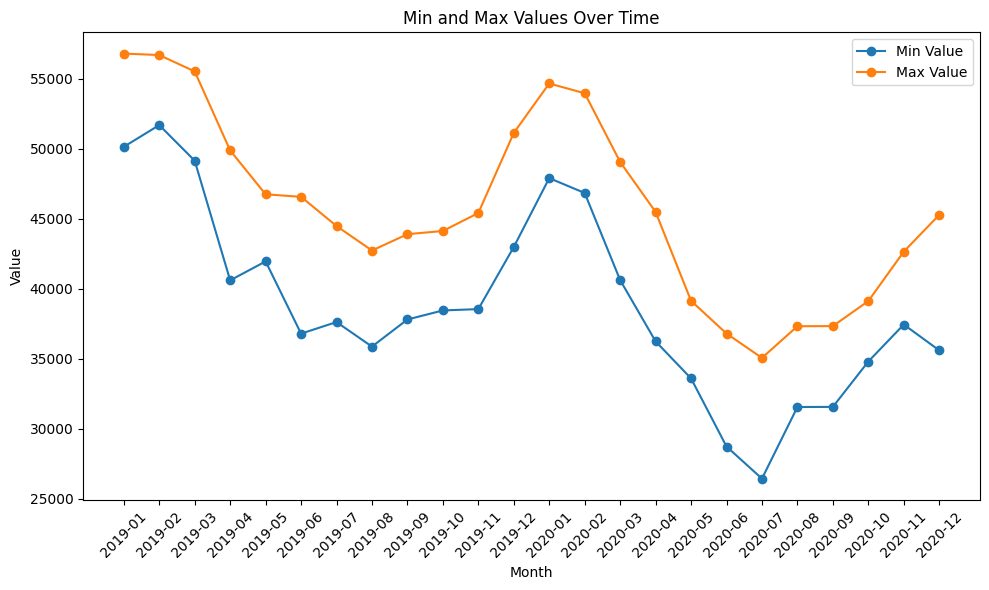

In [21]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(result_df['yyyy-mm'], result_df['min'], label='Min Value', marker='o')
plt.plot(result_df['yyyy-mm'], result_df['max'], label='Max Value', marker='o')
plt.xlabel('Month')
plt.ylabel('Value')
plt.title('Min and Max Values Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

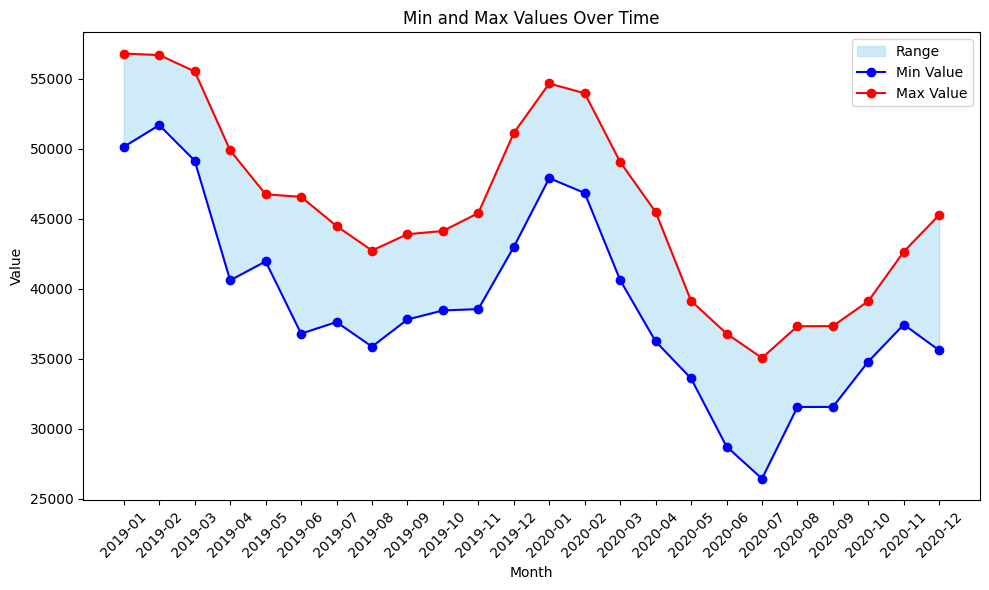

In [23]:
# Plotting
plt.figure(figsize=(10, 6))

# Plot the shaded area between min and max values
plt.fill_between(result_df['yyyy-mm'], result_df['min'], result_df['max'], color='skyblue', alpha=0.4, label='Range')
plt.plot(result_df['yyyy-mm'], result_df['min'], color='blue', label='Min Value', marker='o')
plt.plot(result_df['yyyy-mm'], result_df['max'], color='red', label='Max Value', marker='o')

plt.xlabel('Month')
plt.ylabel('Value')
plt.title('Min and Max Values Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()